<a href="https://colab.research.google.com/github/miguelangelortizpenaranda/ortizpastorserna/blob/main/bandit_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Grupo 1: Bandido de K-Brazos (Distribución binomial general)

Autores:

- Miguel Ángel Ortiz Peñaranda
- Miguel Pastor Beltrá
- Rubén Serna

## Introducción

El bandido de k-brazos, o k-armed bandit, supone un problema clásico de aprendizaje por refuerzo. En él, disponemos de un número K de elementos que, al activarlos, nos otorgan una recompensa determinada, desconocida a priori. Es esta recompensa la que nos interesa maximizar a lo largo del tiempo, por medio de un método que, bien explore distintos "brazos" o soluciones, bien explote la solución que en un momento dado parezca la mejor, o bien mediante un compendio de ambas prácticas.




## Preparación del entorno

Para el funcionamiento de este notebook por parte de Colab, es necesario ejecutar las líneas de código que se encuentran a continuación,
las cuales se encargan de clonar el repositorio para que el código esté disponible por parte de este notebook.


In [12]:
#!rm -r ortizpastorserna/
#!git clone https://github.com/miguelangelortizpenaranda/ortizpastorserna.git
#!cd ortizpastorserna/

A continuación añadimos al path los directorios de código fuente, tanto para ejecución en Colab como para ejecución en un IDE local.

In [13]:
#@title Importamos todas las clases y funciones
import sys

# Añadir los directorios fuentes al path de Python
sys.path.append('/content/ortizpastorserna/src/eml_k_bandit')
sys.path.append('src/eml_k_bandit')

# Verificar que se han añadido correctamente
print(sys.path)

#!ls


['C:\\Users\\shera\\AppData\\Local\\Programs\\PyCharm\\plugins\\python-ce\\helpers\\jupyter_debug', 'C:\\Users\\shera\\AppData\\Local\\Programs\\PyCharm\\plugins\\python-ce\\helpers\\pydev', 'C:\\Users\\shera\\PycharmProjects\\ortizpastorserna', 'C:\\Users\\shera\\PycharmProjects\\ortizpastorserna\\src', 'C:\\Users\\shera\\PycharmProjects\\ortizpastorserna\\.venv\\Scripts\\python313.zip', 'C:\\Users\\shera\\AppData\\Local\\Programs\\Python\\Python313\\DLLs', 'C:\\Users\\shera\\AppData\\Local\\Programs\\Python\\Python313\\Lib', 'C:\\Users\\shera\\AppData\\Local\\Programs\\Python\\Python313', 'C:\\Users\\shera\\PycharmProjects\\ortizpastorserna\\.venv', '', 'C:\\Users\\shera\\PycharmProjects\\ortizpastorserna\\.venv\\Lib\\site-packages', '/content/ortizpastorserna/src/eml_k_bandit', 'src/eml_k_bandit', '/content/ortizpastorserna/src/eml_k_bandit', 'src/eml_k_bandit']


Realizamos los imports correspondientes a los tipos implementados de variantes del bandido de k-brazos, así como los algoritmos que se han modelado, y algunas otras librerías adicionales para representación de los resultados.

In [14]:

import numpy as np
from typing import List

from algorithms import Algorithm, EpsilonGreedy, UCB1, Softmax
from arms import ArmNormal, ArmBinomial, Bandit
from plotting import plot_average_rewards, plot_optimal_selections, plot_regret

Fijamos la semilla aleatoria para asegurar la reproducibilidad de los resultados de las ejecuciones en distintos dispositivos.

In [15]:
seed = 1234
np.random.seed(seed)  # Fijar la semilla para reproducibilidad

## Experimento

Este código se encarga de ejecutar un número de `runs` concretos para el problema de k-armed bandit. Utilizando una lista de algoritmos y ejecutando cada algoritmo una serie de pasos, para acabar obteniendo un promedio de recompensas por ejecución, así como el porcentaje de selecciones del brazo óptimo para dichas ejecuciones.


In [16]:

def run_experiment(bandit: Bandit, algorithms: List[Algorithm], steps: int, runs: int):

    """
    Ejecuta el problema del bandido de k-brazos un número de runs concretos, una serie de pasos para cada algoritmo especificado.
    :param bandit: Implementación del bandido de k-brazos a ejecutar
    :param algorithms: Listado de algoritmos a ejecutar para esa implementación del bandido
    :param steps: Número de pasos a ejecutar para cada algoritmo individual
    :param runs: Número de ejecuciones independientes que se va a hacer para todos y cada uno de los algoritmos
    :return: Promedio de recompensas, arrepentimiento acumulado, y porcentaje de soluciones óptimas
    """
    optimal_arm = bandit.optimal_arm  # Se elige el brazo óptimo en base a la implementación del bandido. Necesario para calcular el porcentaje de selecciones óptimas.
    rewards = np.zeros((len(algorithms), steps)) # Matriz para almacenar las recompensas promedio.
    regrets = np.zeros((len(algorithms), steps)) # Matriz para almacenar el regret
    optimal_selections = np.zeros((len(algorithms), steps))  # Matriz para almacenar el porcentaje de selecciones óptimas.

    np.random.seed(seed)  # Asegurar reproducibilidad de resultados.

    for run in range(runs):
        current_bandit = Bandit(arms=bandit.arms) # Crea una instancia nueva del bandido con la distribución que especifica la implementación parada como parámetro (normal, binomial)

        for algo in algorithms:
            algo.reset() # Reiniciar los valores de los algoritmos.

        total_rewards_per_algo = np.zeros(len(algorithms)) # Acumulador de recompensas por algoritmo. Necesario para calcular el promedio.

        for step in range(steps):
            for idx, algo in enumerate(algorithms):
                chosen_arm = algo.select_arm() # Seleccionar un brazo según la política del algoritmo.
                reward = current_bandit.pull_arm(chosen_arm) # Obtener la recompensa del brazo seleccionado.
                algo.update(chosen_arm, reward) # Actualizar el valor estimado del brazo seleccionado.

                optimal_reward = bandit.arms[optimal_arm].get_expected_value() # Recompensa óptima, para calcular regret

                rewards[idx, step] += reward # Acumular la recompensa obtenida en la matriz rewards para el algoritmo idx en el paso step.
                regrets[idx, step] += (optimal_reward - reward) # Acumulamos arrepentimiento como diferencia entre recompensa óptima y la obtenida
                total_rewards_per_algo[idx] += reward # Acumular la recompensa obtenida en total_rewards_per_algo para el algoritmo idx.

                 # Modificamos optimal_selections cuando el brazo elegido se corresponda con el brazo óptimo optimal_arm
                if chosen_arm == optimal_arm:
                  optimal_selections[idx, step] += 1

    # Promediamos recompensas entre ejecuciones
    rewards /= runs

    # Promediamos arrepentimientos entre ejecuciones
    regrets /= runs
    # Calculamos arrepentimiento acumulado a lo largo del array
    cumulative_regret = np.cumsum(regrets, axis=1)

    # Calculamos el porcentaje de selecciones óptimas y almacenar en optimal_selections
    optimal_selections /= runs
    optimal_selections *= 100

    return rewards, cumulative_regret, optimal_selections


## Ejecución del experimento

A continuación, utilizando la función definida anteriormente, vamos a ejecutar el experimento del bandido. Esto se va a realizar para las dos variantes del bandido:
- Variante con distribución normal, con desviación 1.
- Variante con distribución binomial, con una probabilidad entre 0.1 y 0.9 por brazo, y recompensa máxima = 1 por brazo (Distribución de Bernoulli).

Adicionalmente, se va a probar con una serie de algoritmos:
- Epsilon Greedy, con valores de epsilon=[0, 0.01, 0.1], que determinan un comportamiento exploratorio cada vez mayor.
- UCB-1, con c=1
- Softmax, con una temperatura de 0.5

Estos algoritmos se van a probar para cada variante del experimento, y mostraremos el promedio de recompensa y el porcentaje de decisiones acertadas para el mejor brazo en cada caso.
Para ello, elegimos un número de brazos de 20, un número de pasos de 1000, y en 500 ejecuciones.

Por último, visualizaremos los resultados para cada bandido, comparando el comportamiento de los distintos algoritmos.

Bandit with 20 arms: ArmBinomial(n=10, p=0.25), ArmBinomial(n=10, p=0.6), ArmBinomial(n=10, p=0.45), ArmBinomial(n=10, p=0.72), ArmBinomial(n=10, p=0.73), ArmBinomial(n=10, p=0.32), ArmBinomial(n=10, p=0.74), ArmBinomial(n=10, p=0.87), ArmBinomial(n=10, p=0.8), ArmBinomial(n=10, p=0.39), ArmBinomial(n=10, p=0.5), ArmBinomial(n=10, p=0.67), ArmBinomial(n=10, p=0.59), ArmBinomial(n=10, p=0.85), ArmBinomial(n=10, p=0.11), ArmBinomial(n=10, p=0.16), ArmBinomial(n=10, p=0.55), ArmBinomial(n=10, p=0.81), ArmBinomial(n=10, p=0.65), ArmBinomial(n=10, p=0.4)
Optimal arm for bandit is: 8 with expected reward=8.7



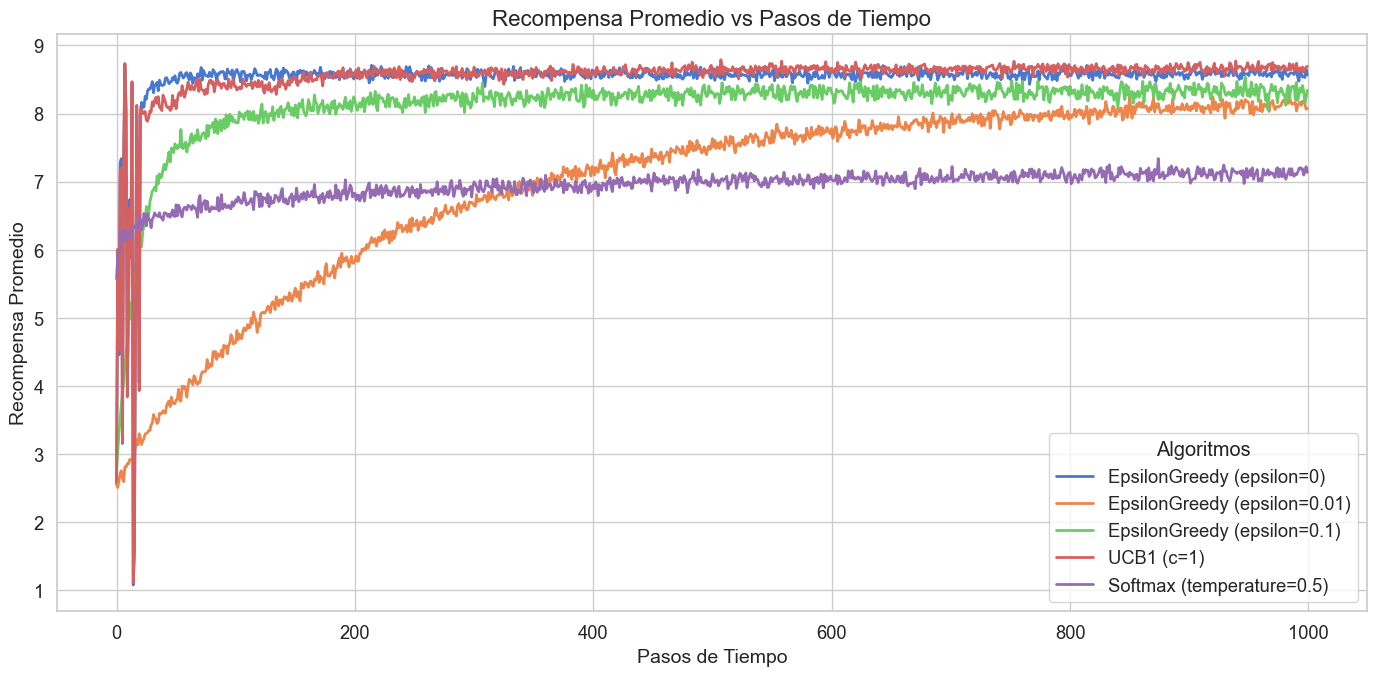

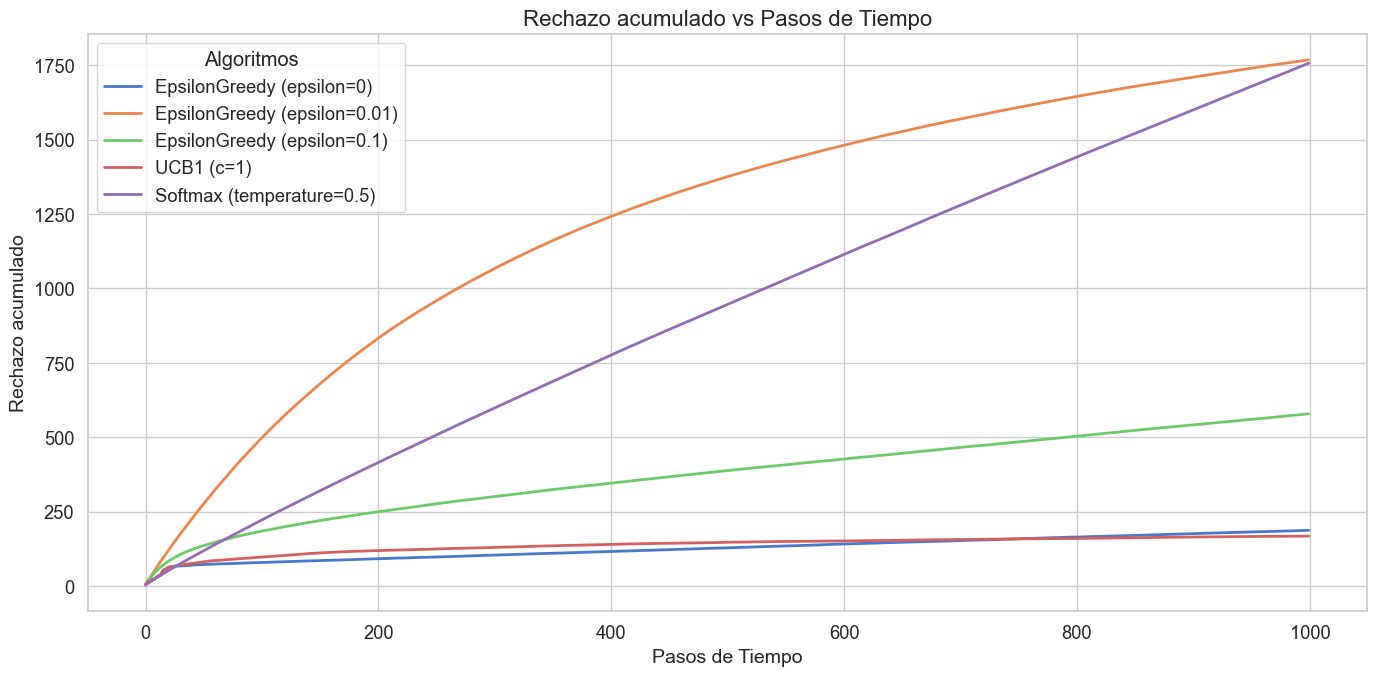

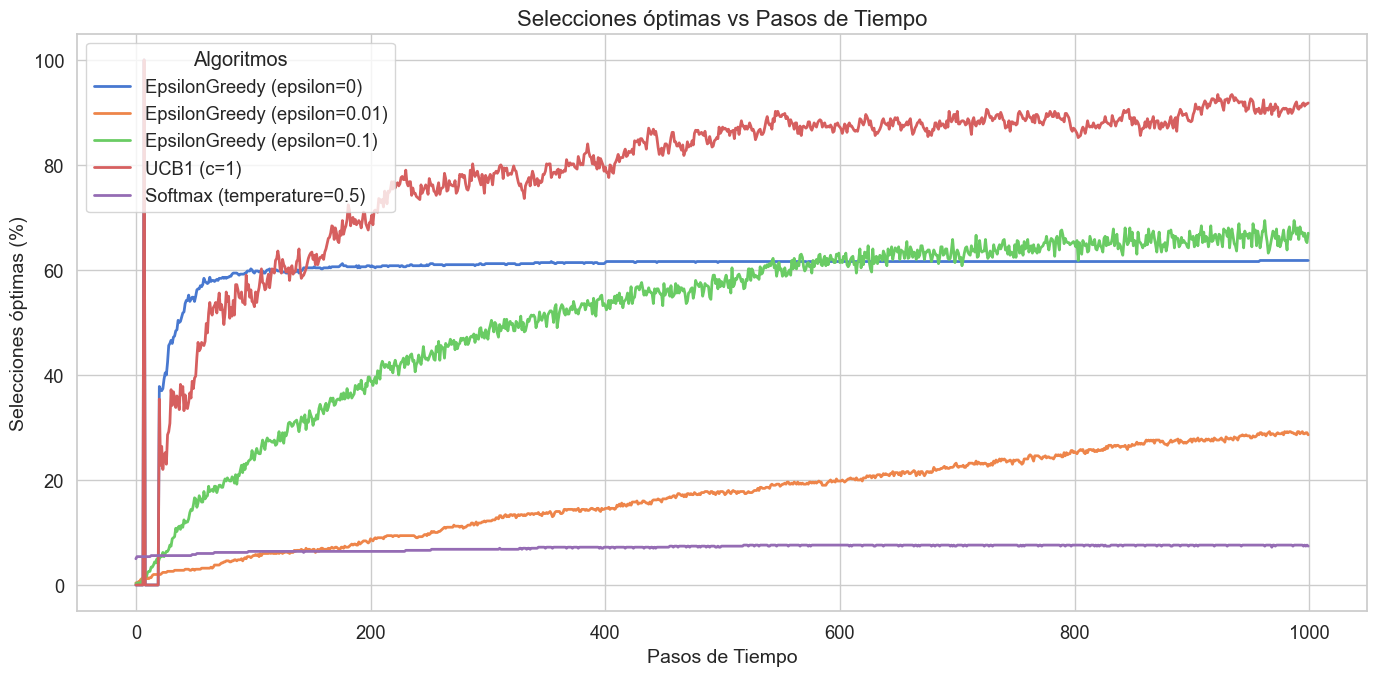

In [17]:

# Parámetros del experimento

k = 20  # Número de brazos
steps = 1000  # Número de pasos que se ejecutarán cada algoritmo
runs = 500  # Número de ejecuciones

# Creación de las variantes del bandit
bandit = Bandit(arms=ArmBinomial.generate_arms(k, n=10)) # Generar un bandido con k brazos de distribución binomial. El valor de n será 10 (máxima recompensa = 10)

# Definir los algoritmos a comparar. En este caso son 3 algoritmos epsilon-greedy con diferentes valores de epsilon.
algorithms = [EpsilonGreedy(k=k, epsilon=0), EpsilonGreedy(k=k, epsilon=0.01), EpsilonGreedy(k=k, epsilon=0.1), UCB1(k=k, c=1), Softmax(k=k, temperature=0.5)]


print(bandit)
optimal_arm = bandit.optimal_arm
print(f"Optimal arm for bandit is: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}\n")
# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards, regrets, optimal_selections = run_experiment(bandit, algorithms, steps, runs)
# Graficar los resultados
plot_average_rewards(steps, rewards, algorithms)
plot_regret(steps, regrets, algorithms)
plot_optimal_selections(steps, optimal_selections, algorithms)


## Análisis de la imagen


## Conclusiones
